In [1]:
#Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

#Loads the data and quick check
train = pd.read_csv('.../Kaggle/Shelter/train.csv')
test = pd.read_csv('.../Kaggle/Shelter/test.csv')

train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [2]:
#Finding the nulls in train data
train.isnull().any()
#test.isnull().any()

AnimalID          False
Name               True
DateTime          False
OutcomeType       False
OutcomeSubtype     True
AnimalType        False
SexuponOutcome     True
AgeuponOutcome     True
Breed             False
Color             False
dtype: bool

In [3]:
#Data type checks
train.info()
print("----------------------------")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.2+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11456 entries, 0 to 11455
Data columns (total 8 columns):
ID                11456 non-null int64
Name              8231 non-null object
DateTime          11456 non-null object
AnimalType        11456 non-null object
SexuponOutcome    11456 non-null object
AgeuponOutcome    11450 non-null object
Breed             11456 non-null object
Color             11456 non-null ob

In [4]:
#Description of the data set
train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A698874,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [5]:
#Drop unnecessary columns

#train.drop("AgeuponOutcome",axis=1,inplace=True)
#test.drop("AgeuponOutcome",axis=1,inplace=True)

train.drop("OutcomeSubtype",axis=1,inplace=True)

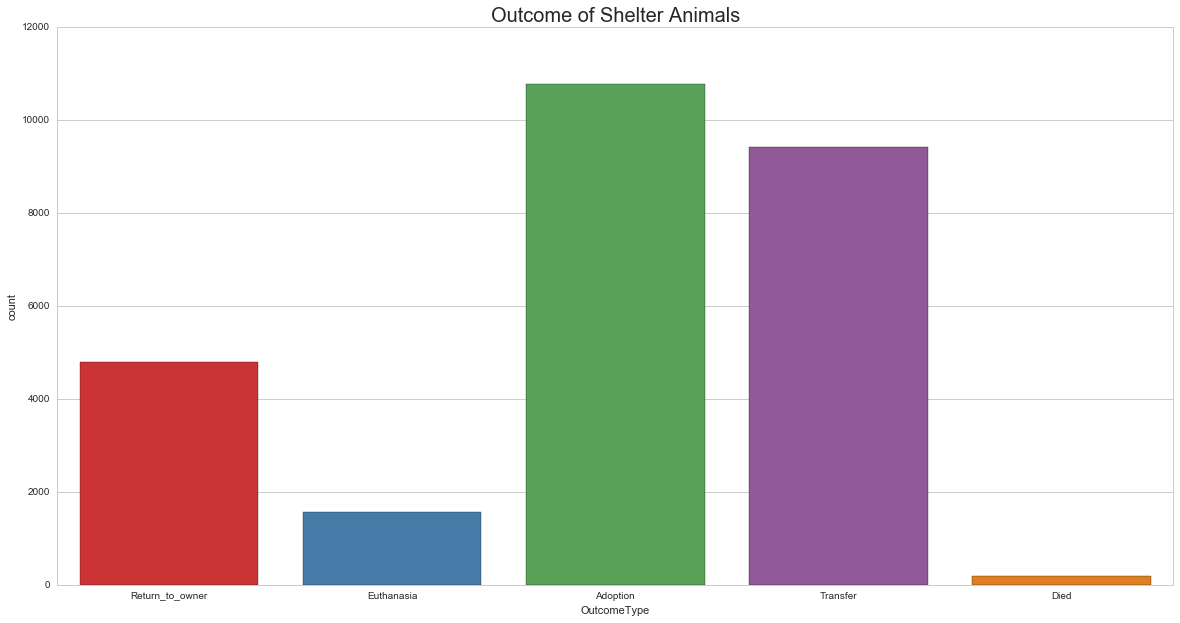

In [6]:
#First chart: What's the outcome of animals going into the shelter?
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
sns.countplot(train.OutcomeType, palette='Set1')
sns.plt.title('Outcome of Shelter Animals', size=20)

## Most animals from this shelter are either adopted or transfered.

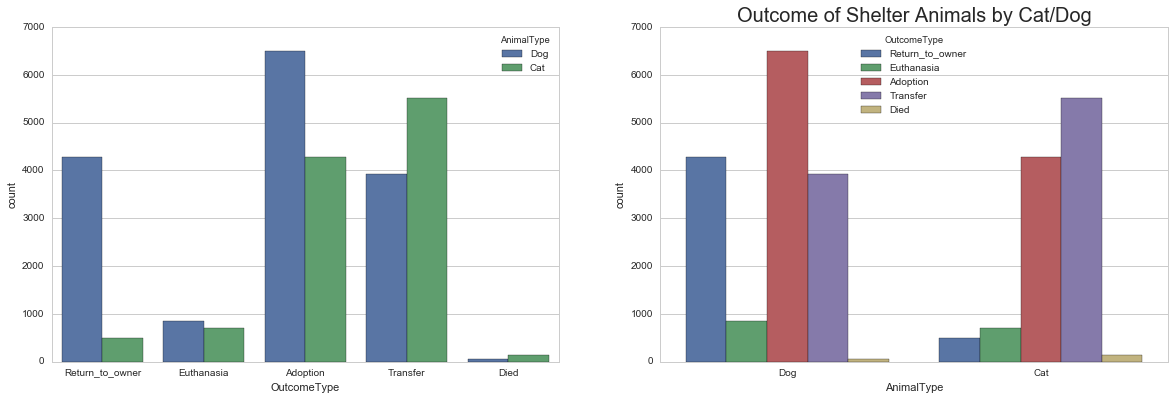

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.countplot(data=train, x='OutcomeType',hue='AnimalType', ax=ax1)
sns.countplot(data=train, x='AnimalType',hue='OutcomeType', ax=ax2)
sns.plt.title('Outcome of Shelter Animals by Cat/Dog', size=20)

## More dogs are adopted and returned to owner, while cats had a higher count of transfering shelters.

In [8]:
#Currently age is a mess and recorded differently--this converts all of the AgeuponOutcome values into weeks:

def convert_AgeuponOutcome_to_weeks(df):
    result = {}
    for k in df['AgeuponOutcome'].unique():
        if type(k) != type(""):
            result[k] = -1
        else:
            v1, v2 = k.split()
            if v2 in ["year", "years"]:
                result[k] = int(v1) * 52
            elif v2 in ["month", "months"]:
                result[k] = int(v1) * 4.5
            elif v2 in ["week", "weeks"]:
                result[k] = int(v1)
            elif v2 in ["day", "days"]:
                result[k] = int(v1) / 7
                
    df['_AgeuponOutcome'] = df['AgeuponOutcome'].map(result).astype(float)
    df = df.drop('AgeuponOutcome', axis = 1)
                
    return df

train = convert_AgeuponOutcome_to_weeks(train)
test = convert_AgeuponOutcome_to_weeks(test)


In [9]:
#Fixing the DateTime column by splitting out year, month, day, hour, minute

def fix_date_time(df):
    def extract_field(_df, start, stop):
        return _df['DateTime'].map(lambda dt: int(dt[start:stop]))
    df['Year'] = extract_field(df,0,4)
    df['Month'] = extract_field(df,5,7)
    df['Day'] = extract_field(df,8,10)
    df['Hour'] = extract_field(df,11,13)
    df['Minute'] = extract_field(df,14,16)
    
    return df.drop(['DateTime'], axis = 1)

train = fix_date_time(train)
test = fix_date_time(test)


In [10]:
#Converting all of the remaining features (Name, Breed, Color, OutcomeType, SexuponOutcome, AnimalType) to numeric values

def convert_to_numeric(df):
    for col in ['Name', 'AnimalType', 'SexuponOutcome',
                'Breed', 'Color', 'OutcomeType']:
        if col in df.columns:
            _col = "_%s" % (col)
            values = df[col].unique()
            _values = dict(zip(values, range(len(values))))
            df[_col] = df[col].map(_values).astype(int)
            df = df.drop(col, axis = 1)
    return df

train = convert_to_numeric(train)
test = convert_to_numeric(test)


In [ ]:
#add a column with Spayed/Neutered/Intact

operation = pd.concat([test['_Operation'], train_df['Operation']])
values = dict(names.value_counts())

train_df['_NameFreq'] = train_df['Name'].map(values)
test_df['_NameFreq'] = test_df['Name'].map(values)

train_df['_NameFreq'] = train_df['_NameFreq'].fillna(99999)
test_df['_NameFreq'] = test_df['_NameFreq'].fillna(99999)

print(test_df.info())
print(train_df.info())

In [11]:
train.head()

,AnimalID,_AgeuponOutcome,Year,Month,Day,Hour,Minute,_Name,_AnimalType,_SexuponOutcome,_Breed,_Color,_OutcomeType
0,A671945,52,2014,2,12,18,22,0,0,0,0,0,0
1,A656520,52,2013,10,13,12,44,1,1,1,1,1,1
2,A686464,104,2015,1,31,12,28,2,0,0,2,2,2
3,A683430,3,2014,7,11,19,9,3,1,2,1,3,3
4,A667013,104,2013,11,15,12,52,3,0,0,3,4,3


In [12]:
#Finding the nulls in train data
train.isnull().any()

AnimalID           False
_AgeuponOutcome    False
Year               False
Month              False
Day                False
Hour               False
Minute             False
_Name              False
_AnimalType        False
_SexuponOutcome    False
_Breed             False
_Color             False
_OutcomeType       False
dtype: bool

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 13 columns):
AnimalID           26729 non-null object
_AgeuponOutcome    26729 non-null float64
Year               26729 non-null int64
Month              26729 non-null int64
Day                26729 non-null int64
Hour               26729 non-null int64
Minute             26729 non-null int64
_Name              26729 non-null int32
_AnimalType        26729 non-null int32
_SexuponOutcome    26729 non-null int32
_Breed             26729 non-null int32
_Color             26729 non-null int32
_OutcomeType       26729 non-null int32
dtypes: float64(1), int32(6), int64(5), object(1)
memory usage: 2.2+ MB


In [14]:
train.describe()

,_AgeuponOutcome,Year,Month,Day,Hour,Minute,_Name,_AnimalType,_SexuponOutcome,_Breed,_Color,_OutcomeType
count,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
mean,113.363575,2014.430731,6.925736,15.698343,14.445396,27.681170,1294.569606,0.416551,1.151558,101.805081,30.726178,1.950952
std,154.068005,0.741408,3.495869,8.770496,3.337331,18.189427,1672.197847,0.492996,1.169985,220.202490,40.251600,1.074254
min,-1.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,2014.000000,4.000000,8.000000,12.000000,12.000000,3.000000,0.000000,0.000000,1.000000,10.000000,2.000000
50%,52.000000,2014.000000,7.000000,16.000000,15.000000,27.000000,493.000000,0.000000,1.000000,16.000000,18.000000,2.000000
75%,156.000000,2015.000000,10.000000,23.000000,17.000000,43.000000,2045.000000,1.000000,2.000000,75.000000,34.000000,3.000000
max,1040.000000,2016.000000,12.000000,31.000000,23.000000,59.000000,6374.000000,1.000000,5.000000,1379.000000,365.000000,4.000000


In [15]:
#train.drop("_NameFreq",axis=1,inplace=True)

In [16]:
# re-index train_df so that ID is first and Target (_OutcomeType) is last
#I took out name frequency 

train = train.reindex(columns = ['AnimalID', '_Name', '_AnimalType', '_SexuponOutcome',
                                       '_AgeuponOutcome', '_Breed', '_Color',
                                       'Year', 'Month', 'Day', 'Hour', 'Minute',
                                       '_OutcomeType'])

In [17]:
#Splitting the data into a training set (85%) and a validation set (15%)

cut = int(len(train) * 0.85)
_validation = train[cut:]
_train = train[:cut]

print(len(_train))
print(len(_validation))

22719
4010


In [18]:
#Starting with an Adaboost Classifier

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2),
                        n_estimators = 100,
                        learning_rate = 0.1)

classifiers = [c.fit(_train.values[:,1:-1],
                     _train.values[:,-1].astype(int)) \
               for c in [Ada1]]
results = [c.predict_proba(_validation.values[:,1:-1]) \
           for c in classifiers]
print(results[0])

[[ 0.24274342  0.18711334  0.2497083   0.23481698  0.08561796]
 [ 0.1952804   0.22705222  0.09071099  0.29157636  0.19538004]
 [ 0.22086275  0.19683636  0.21643872  0.21159141  0.15427075]
 ..., 
 [ 0.23549083  0.18718098  0.23159674  0.2228382   0.12289324]
 [ 0.16451204  0.23353061  0.0889759   0.29619369  0.21678777]
 [ 0.14391174  0.20038822  0.14131673  0.29512974  0.21925357]]


In [19]:
#Log loss (classification loss function) is used as an eval metric in kaggle competitions.  It quantifies the accuracy of a 
#classifier by penalising false classifications.
#https://www.kaggle.com/wiki/LogarithmicLoss

from sklearn.metrics import log_loss

print([log_loss(_validation.values[:,-1].astype(int), r) for r in results])

[1.3735186201179623]


In [20]:
#Now, rebuilding the adaboost classifier on the entire training set, instead of just 85%

ab = classifiers[0].fit(train.values[:,1:-1],
                        train.values[:,-1].astype(int))

# and use the classifier on test_df

ab_result = ab.predict_proba(test.values[:,1:])
ab_sub_df = pd.DataFrame(ab_result, columns=['Adoption', 'Died', 'Euthanasia',
                                             'Return_to_owner', 'Transfer'])
ab_sub_df.insert(0, 'ID', test.values[:,0].astype(int))

print(ab_sub_df)

# write to submission files

ab_sub_df.to_csv(".../Kaggle/Shelter/Sheltersubmission.csv", index = False)


          ID  Adoption      Died  Euthanasia  Return_to_owner  Transfer
0          1  0.156416  0.165491    0.190717         0.280526  0.206849
1          2  0.164793  0.210775    0.196456         0.229888  0.198087
2          3  0.171224  0.167088    0.261092         0.223591  0.177004
3          4  0.161444  0.209948    0.191985         0.229087  0.207535
4          5  0.164793  0.210775    0.196456         0.229888  0.198087
5          6  0.162255  0.208005    0.194971         0.229130  0.205638
6          7  0.151970  0.202791    0.204890         0.232647  0.207701
7          8  0.161444  0.209948    0.191985         0.229087  0.207535
8          9  0.151965  0.203447    0.200911         0.232539  0.211138
9         10  0.151280  0.210902    0.188204         0.233506  0.216107
10        11  0.226381  0.151662    0.166494         0.300622  0.154841
11        12  0.156952  0.210681    0.192492         0.225581  0.214293
12        13  0.177553  0.182117    0.242528         0.218251  0